In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab.patches import cv2_imshow

In [73]:
cd /content/drive/MyDrive/제목없는 폴더/drive-download-20220113T145103Z-001.zip (Unzipped Files)

/content/drive/MyDrive/제목없는 폴더/drive-download-20220113T145103Z-001.zip (Unzipped Files)


In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import datetime
import os, sys, glob
plt.style.use('dark_background')

In [ ]:
!git clone https://github.com/opencv/opencv
!git clone https://github.com/opencv/opencv_contrib

Cloning into 'opencv'...
remote: Enumerating objects: 301895, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 301895 (delta 0), reused 1 (delta 0), pack-reused 301894
Receiving objects: 100% (301895/301895), 491.32 MiB | 14.40 MiB/s, done.
Resolving deltas: 100% (210029/210029), done.
Checking out files: 100% (6970/6970), done.
Cloning into 'opencv_contrib'...
remote: Enumerating objects: 36357, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 36357 (delta 0), reused 6 (delta 0), pack-reused 36350
Receiving objects: 100% (36357/36357), 132.08 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (22569/22569), done.


# Read and Analyze Labels

In [ ]:
labels = pd.read_csv('train_test_files/All_labels.txt', sep=" ", header=None)
labels.head()

,0,1
0,CF437.jpg,2.883333
1,AM1384.jpg,2.466667
2,AM1234.jpg,2.150000
3,AM1774.jpg,3.750000
4,CF215.jpg,3.033333


In [ ]:
labels.describe()

,1
count,5500.000000
mean,2.990891
std,0.688112
min,1.016667
25%,2.500000
50%,2.833333
75%,3.533333
max,4.750000


# Dataframe to Numpy Array

In [ ]:
labels_np = labels.values
print(labels_np[:5])

[['CF437.jpg' 2.8833330000000004]
 ['AM1384.jpg' 2.4666669999999997]
 ['AM1234.jpg' 2.15]
 ['AM1774.jpg' 3.75]
 ['CF215.jpg' 3.0333330000000003]]


# Read Images

In [ ]:
import os
from keras_preprocessing import image

In [ ]:
imgs = np.empty((len(labels_np), 350, 350, 3), dtype=np.uint8)

for i, (img_filename, rating) in enumerate(labels_np):

    img = cv2.imread(os.path.join('/content/drive/MyDrive/코랩으로 한 번 해보자/22-01-07 프로젝트/Images', img_filename))
    
    if img.shape[0] != 350 or img.shape[1] != 350:
        print(img_filename)
        
imgs[i] = img

# Split Train and Validation Dataset

# Load Dataset

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(imgs, labels_np[:, 1], test_size=0.4)
np.save('x_train.npy', x_train)
np.save('x_val.npy', x_val)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

In [ ]:
x_train = np.load('x_train.npy', allow_pickle=True)
y_train = np.load('y_train.npy', allow_pickle=True)
x_val = np.load('x_val.npy', allow_pickle=True)
y_val = np.load('y_val.npy', allow_pickle=True)

FileNotFoundError: ignored

# Plot Samples

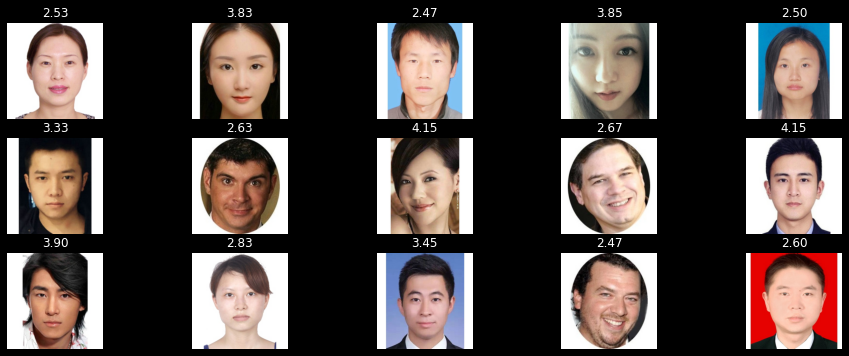

In [ ]:
plt.figure(figsize=(16, 6))
for i, img in enumerate(x_train[:15]):
    plt.subplot(3, 5, i+1)
    plt.axis('off')
    plt.title('%.2f' % y_train[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [ ]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.float32)

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,             # 리스케일 시켜주고
    rotation_range=45,          # 기울기를 40 도 정도 넣어주고
    shear_range=0.3,            # 찌그러 트리고
    zoom_range=0.4,             # 확대시키거나, 축소 시키는거
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

# Plot Augmented Images

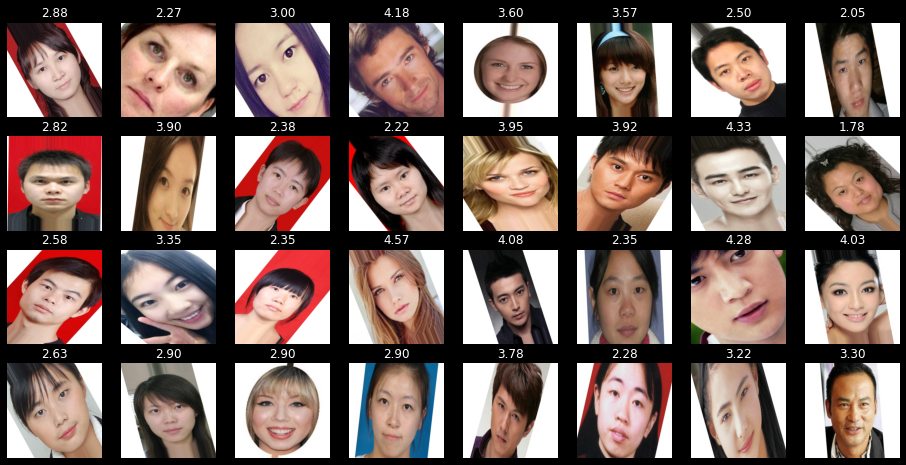

In [ ]:
augs = train_generator.__getitem__(8)

plt.figure(figsize=(16, 8))
for i, img in enumerate(augs[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f' % augs[1][i])
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

# Create Model

In [ ]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

# 모델 복원
loaded_model = tf.keras.models.load_model('models/구2.h5')
loaded_model.summary()

loss, acc = loaded_model.evaluate(x_test, y_test, verbose=2)
print('Loss: ', loss)
print('Acc: ', acc)

In [ ]:
inputs = Input(shape=(350, 350, 3))

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)


net = Dense(256)(net)
net = Activation('relu')(net)
net = Dense(256)(net)
net = Activation('relu')(net)
net = Dense(128)(net)
net = Activation('relu')(net)
net = Dense(64)(net)
net = Activation('relu')(net)
net = Dense(32)(net)
net = Activation('relu')(net)
net = Dense(16)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('linear')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 350, 350, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 350, 350, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 175, 175, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 175, 32)      9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 175, 175, 32)      0         
                                                             

# Train

In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=2, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/2
104/104 [==============================] - ETA: 0s - loss: 0.3020
Epoch 00001: val_loss improved from inf to 0.28876, saving model to models/2022_01_14_01_38_05.h5
104/104 [==============================] - 704s 7s/step - loss: 0.3020 - val_loss: 0.2888
Epoch 2/2
104/104 [==============================] - ETA: 0s - loss: 0.2884
Epoch 00002: val_loss improved from 0.28876 to 0.27624, saving model to models/2022_01_14_01_38_05.h5
104/104 [==============================] - 708s 7s/step - loss: 0.2884 - val_loss: 0.2762


# Evaluate Validation Dataset

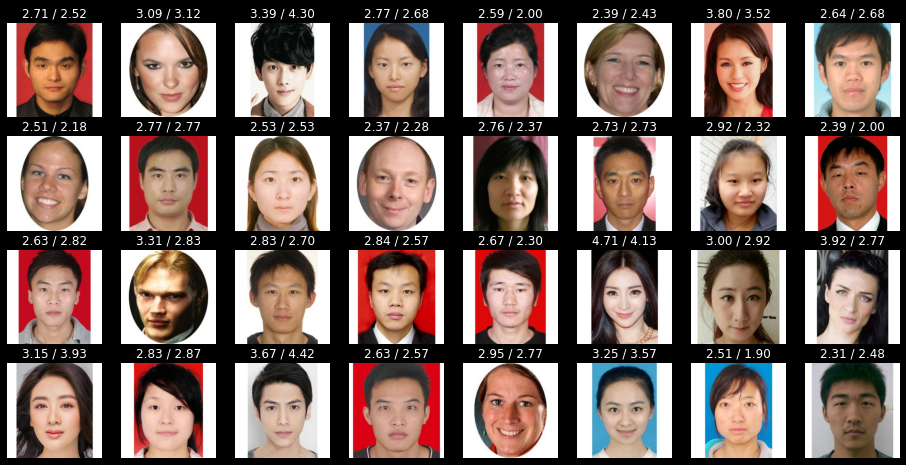

In [ ]:
model = load_model('models/구2.h5')

val_data = val_generator.__getitem__(0)

preds = model.predict(val_data[0])

plt.figure(figsize=(16, 8))
for i, img in enumerate(val_data[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f / %.2f' % (preds[i], val_data[1][i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

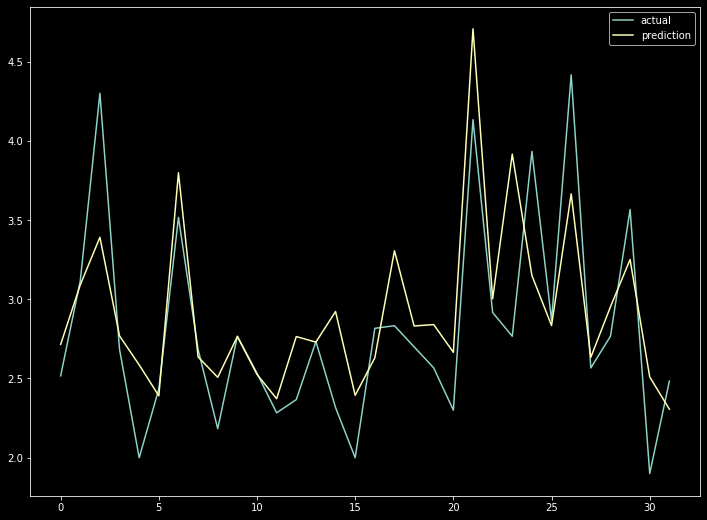

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_val)[:32], label='actual')
plt.plot(preds, label='prediction')
plt.legend()
plt.show()

# Test Model with Wild Dataset

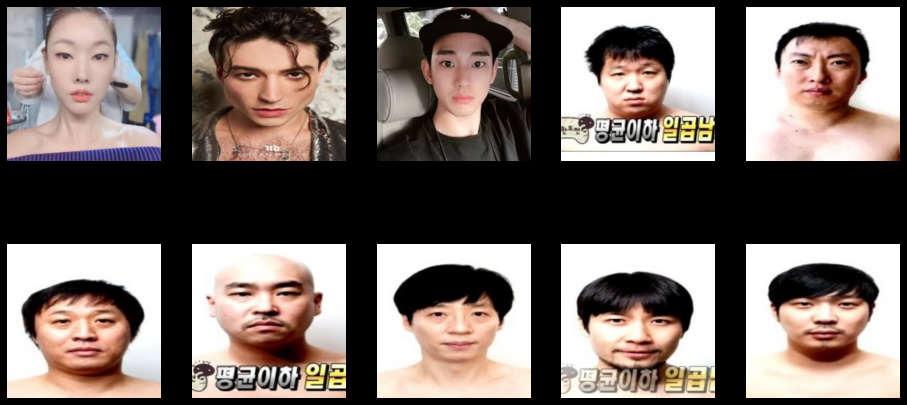

In [ ]:
img_test_list = glob.glob('img/*.jpg')

imgs_test_resized = []

plt.figure(figsize=(16, 8))
for i, img_path in enumerate(img_test_list):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (350, 350))

    plt.subplot(2, 5, i+1)
    plt.axis('off')
    img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())
    
    img_resized = img_resized.astype(np.float32) / 255.
    imgs_test_resized.append(img_resized)

imgs_test_resized = np.array(imgs_test_resized, dtype=np.float32)

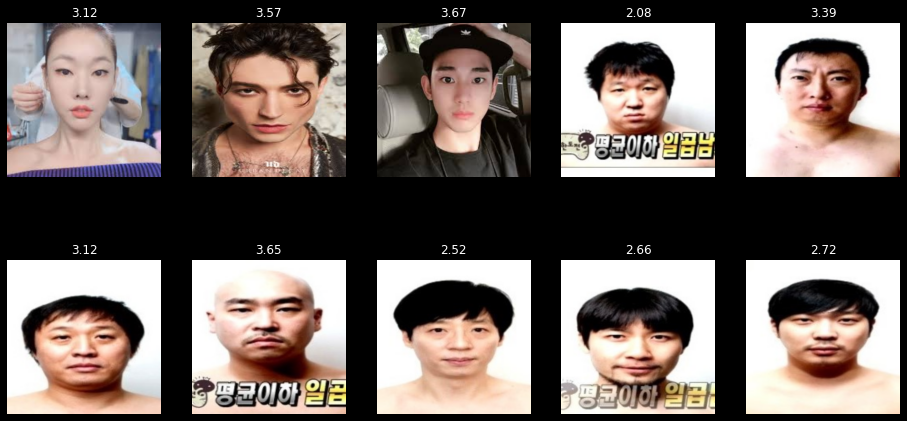

In [ ]:
preds = model.predict(imgs_test_resized)

plt.figure(figsize=(16, 8))
for i, img in enumerate(imgs_test_resized):
    plt.subplot(2, 5, i+1)
    plt.title('%.2f' % (preds[i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

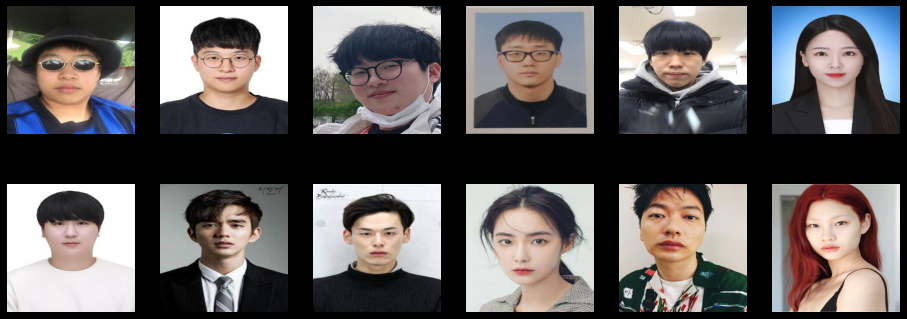

In [ ]:
img_test_list = sorted(glob.glob('img/KM/*.jpg'))

imgs_test_resized = []

plt.figure(figsize=(16, 6))
for i, img_path in enumerate(img_test_list):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (350, 350))

    plt.subplot(2, 6, i+1)
    plt.axis('off')
    img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())
    
    img_resized = img_resized.astype(np.float32) / 255.
    imgs_test_resized.append(img_resized)

imgs_test_resized = np.array(imgs_test_resized, dtype=np.float32)

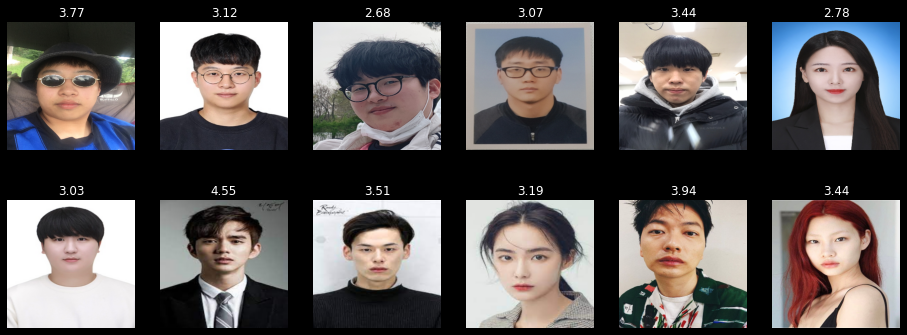

In [ ]:
preds = model.predict(imgs_test_resized)

plt.figure(figsize=(16, 6))
for i, img in enumerate(imgs_test_resized):
    plt.subplot(2, 6, i+1)
    plt.title('%.2f' % (preds[i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())